In [1]:
import os
from pathlib import Path
import re
import sys
sys.path.insert(0,'../../')
from eppy.runner.run_functions import EnergyPlusRunError
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from doe_xstock.database import SQLiteDatabase
from doe_xstock.simulate import OpenStudioModelEditor, Simulator
from doe_xstock.utilities import get_data_from_path, split_lines, read_json, write_data, write_json

In [12]:
pd.DataFrame.from_dict({'a':{0:[1,2,3,4],1:[4,4,4,4]}},)

TypeError: explode() missing 1 required positional argument: 'column'

In [2]:
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
SIMULATION_OUTPUT_DIRECTORY = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/energyplus_simulation')
DATABASE_FILEPATH = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/database.db')
NEIGHBOURHOOD_FILEPATH = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/doe_xstock/data/neighborhoods/travis_county.json')
SCHEDULES_FILENAME = Path('schedules.csv')
IDD_FILEPATH = Path('/Applications/EnergyPlus-9-6-0/PreProcess/IDFVersionUpdater/V9-6-0-Energy+.idd')
NEIGHBOURHOOD = read_json(NEIGHBOURHOOD_FILEPATH)
DATABASE = SQLiteDatabase(DATABASE_FILEPATH)
OUTPUT_VARIABLES = [
    'Lights Electricity Energy','Electric Equipment Electricity Energy',
    'Zone Air Temperature','Zone Air Relative Humidity','Zone Mean Air Temperature',
    'Zone Thermostat Cooling Setpoint Temperature','Zone Thermostat Heating Setpoint Temperature',
    'Water Heater Heating Energy',
    'Zone Predicted Sensible Load to Setpoint Heat Transfer Rate',
    'Zone Predicted Moisture Load Moisture Transfer Rate',
    'Air System Outdoor Air Mass Flow Rate',
    'Air System Fan Electricity Energy',
    'Other Equipment Convective Heating Rate',
    'Zone Air System Sensible Cooling Rate',
    'Zone Air System Sensible Heating Rate',
    'Air System Mechanical Ventilation Flow Rate',
    'Zone Ideal Loads Zone Sensible Cooling Energy','Zone Ideal Loads Zone Sensible Heating Energy',
    'Zone Ideal Loads Zone Latent Cooling Energy','Zone Ideal Loads Zone Latent Heating Energy',
    'Zone Ideal Loads Zone Total Cooling Energy','Zone Ideal Loads Zone Total Heating Energy',
    'Zone Ideal Loads Zone Sensible Cooling Rate','Zone Ideal Loads Zone Sensible Heating Rate',
    'Zone Ideal Loads Zone Latent Cooling Rate','Zone Ideal Loads Zone Latent Heating Rate',
    'Zone Ideal Loads Zone Total Cooling Rate','Zone Ideal Loads Zone Total Heating Rate',
]
OUTPUT_SCHEMA_FILEPATH = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/doe_xstock/analysis/output_schema.sql')
OUTPUT_QUERY = get_data_from_path(OUTPUT_SCHEMA_FILEPATH)

# WORKFLOW 1 (Ideal Air Loads System)
***

In [3]:
# functions
def get_schedule_data(size,seed=0,minimum_value=0.3,maximum_value=1.7,probability=0.6):
    np.random.seed(seed)
    schedule = np.random.uniform(minimum_value,maximum_value,size)
    schedule[np.random.random(size) > probability] = 1
    return schedule.tolist()

def get_simulation_summary(filepath,cooled_zone_ixs=None,heated_zone_ixs=None):
    cooled_zone_ixs = [-1] if cooled_zone_ixs is None else cooled_zone_ixs
    heated_zone_ixs = [-1] if heated_zone_ixs is None else heated_zone_ixs
    cooled_zone_ixs = '(' + str(cooled_zone_ixs)[1:-1] + ')'
    heated_zone_ixs = '(' + str(heated_zone_ixs)[1:-1] + ')'
    query = f"""
    WITH zone_conditioning AS (
        SELECT
            ZoneIndex,
            CASE WHEN ZoneIndex IN {cooled_zone_ixs} THEN 1 ELSE 0 END AS is_cooled,
            CASE WHEN ZoneIndex IN {heated_zone_ixs} THEN 1 ELSE 0 END AS is_heated
        FROM Zones

    ), zone AS (
        -- get zone floor area proportion of total zone floor area
        SELECT
            z.ZoneName,
            z.Multiplier,
            z.Volume,
            z.FloorArea,
            (z.FloorArea*z.Multiplier)/t.total_floor_area AS total_floor_area_proportion,
            CASE WHEN c.is_cooled != 0 OR c.is_heated != 0 THEN (z.FloorArea*z.Multiplier)/t.conditioned_floor_area ELSE 0 END AS conditioned_floor_area_proportion,
            c.is_cooled,
            c.is_heated
        FROM Zones z
        CROSS JOIN (
            SELECT
                SUM(z.FloorArea*z.Multiplier) AS total_floor_area,
                SUM(CASE WHEN c.is_cooled != 0 OR c.is_heated != 0 THEN z.FloorArea*z.Multiplier ELSE 0 END) AS conditioned_floor_area
            FROM Zones z
            LEFT JOIN zone_conditioning c ON c.ZoneIndex = z.ZoneIndex
        ) t
        LEFT JOIN zone_conditioning c ON c.ZoneIndex = z.ZoneIndex

    ), unioned_variables AS (
        -- weighted average variable
        SELECT
            r.TimeIndex,
            r.ReportDataDictionaryIndex,
            'air_temperature' AS label,
            NULL AS zone_index,
            NULL AS zone_name,
            r.Value*z.conditioned_floor_area_proportion AS "value"
        FROM ReportData r
        INNER JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
        INNER JOIN "zone" z ON z.ZoneName = d.KeyValue
        WHERE
            (d.Name = 'Zone Mean Air Temperature' AND (z.is_cooled != 0 OR z.is_heated != 0))

        UNION

       -- cooling and heating loads
        SELECT
            r.TimeIndex,
            r.ReportDataDictionaryIndex,
            'cooling_load' AS label,
            z.ZoneIndex AS zone_index,
            z.ZoneName AS zone_name,
            ABS(r.value) AS value
        FROM ReportData r
        INNER JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
        LEFT JOIN Zones z ON z.ZoneName = REPLACE(d.KeyValue, ' IDEAL LOADS AIR SYSTEM', '')
        WHERE d.Name = 'Zone Ideal Loads Zone Sensible Cooling Rate' AND z.ZoneIndex IN {cooled_zone_ixs}
        UNION
        SELECT
            r.TimeIndex,
            r.ReportDataDictionaryIndex,
            'heating_load' AS label,
            z.ZoneIndex AS zone_index,
            z.ZoneName AS zone_name,
            ABS(r.value) AS value
        FROM ReportData r
        INNER JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
        LEFT JOIN Zones z ON z.ZoneName = REPLACE(d.KeyValue, ' IDEAL LOADS AIR SYSTEM', '')
        WHERE d.Name = 'Zone Ideal Loads Zone Sensible Heating Rate' AND z.ZoneIndex IN {heated_zone_ixs}
    ), aggregate_value AS (
        -- sum the variables per timestamp
        SELECT
            u.TimeIndex,
            d.Name,
            d.Units,
            u.label,
            u.zone_name,
            u.zone_index,
            SUM(u.value) AS value
        FROM unioned_variables u
        INNER JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = u.ReportDataDictionaryIndex
        GROUP BY
            u.TimeIndex,
            u.label,
            d.Name,
            d.Units,
            u.zone_name,
            u.zone_index
    )

    SELECT
        t.TimeIndex AS 'timestep',
        t.Month AS 'month',
        t.Day AS 'day',
        t.Hour AS 'hour',
        t.Minute AS 'minute',
        t.DayType AS day_name,
        CASE
            WHEN t.DayType = 'Monday' THEN 1
            WHEN t.DayType = 'Tuesday' THEN 2
            WHEN t.DayType = 'Wednesday' THEN 3
            WHEN t.DayType = 'Thursday' THEN 4
            WHEN t.DayType = 'Friday' THEN 5
            WHEN t.DayType = 'Saturday' THEN 6
            WHEN t.DayType = 'Sunday' THEN 7
            WHEN t.DayType = 'Holiday' THEN 8
            ELSE NULL
        END AS day_of_week,
        a.Name AS output_variable,
        a.Units AS units,
        a.label,
        a.zone_index,
        a.zone_name,
        a.value
    FROM aggregate_value a
    INNER JOIN "Time" t ON t.TimeIndex = a.TimeIndex
    WHERE
        t.DayType NOT IN ('SummerDesignDay', 'WinterDesignDay')
    """
    database = SQLiteDatabase(filepath)
    data = database.query_table(query)
    return data

def get_zone_conditioning_metadata(filepath):
    query = """
    SELECT
        z.ZoneIndex AS zone_index,
        z.ZoneName AS zone_name,
        SUM(CASE WHEN s.Name = 'Zone Thermostat Cooling Setpoint Temperature' AND s.average_setpoint > 0 THEN 1 ELSE 0 END) AS is_cooled,
        SUM(CASE WHEN s.Name = 'Zone Thermostat Heating Setpoint Temperature' AND s.average_setpoint > 0 THEN 1 ELSE 0 END) AS is_heated,
        MAX(CASE WHEN s.Name = 'Zone Thermostat Cooling Setpoint Temperature' THEN s.average_setpoint ELSE NULL END) AS average_cooling_setpoint,
        MAX(CASE WHEN s.Name = 'Zone Thermostat Heating Setpoint Temperature' THEN s.average_setpoint ELSE NULL END) AS average_heating_setpoint
    FROM (
        SELECT
            d.KeyValue,
            d.Name,
            AVG(r."value") AS average_setpoint
        FROM ReportData r
        INNER JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
        WHERE d.Name IN ('Zone Thermostat Cooling Setpoint Temperature', 'Zone Thermostat Heating Setpoint Temperature')
        GROUP BY d.KeyValue, d.Name
    ) s
    LEFT JOIN Zones z ON z.ZoneName = s.KeyValue
    GROUP BY
        z.ZoneName,
        z.ZoneIndex
    """
    database = SQLiteDatabase(filepath)
    data = database.query_table(query)
    return data

In [4]:
bldg_id = NEIGHBOURHOOD[0]
simulation_data = DATABASE.query_table(f"""
SELECT 
    i.metadata_id,
    i.bldg_osm AS osm, 
    i.bldg_epw AS epw
FROM building_energy_performance_simulation_input i
LEFT JOIN metadata m ON m.id = i.metadata_id
WHERE m.bldg_id = {bldg_id}
""")
simulation_data = simulation_data.to_dict(orient='records')[0]
schedule = DATABASE.query_table(f"""SELECT * FROM schedule WHERE metadata_id = {simulation_data['metadata_id']}""")
schedule = schedule.drop(columns=['metadata_id','timestep',])
schedule.to_csv(SCHEDULES_FILENAME,index=False)
write_data(simulation_data['osm'],f'{bldg_id}.osm')

# retrieve osm
simulation_id = f'{bldg_id}'
output_directory = os.path.join(SIMULATION_OUTPUT_DIRECTORY,f'output_{simulation_id}')
osm = simulation_data['osm']
osm_editor = OpenStudioModelEditor(osm)

# add IdealAirLoadsHVAC
osm_editor.use_ideal_loads_air_system()

# convert to idf
idf = osm_editor.forward_translate()
simulator = Simulator(IDD_FILEPATH,idf,simulation_data['epw'],simulation_id=simulation_id,output_directory=output_directory)


# update output variables
idf = simulator.get_idf_object()
idf.idfobjects['Output:Variable'] = []

for output_variable in OUTPUT_VARIABLES:
    obj = idf.newidfobject('Output:Variable')
    obj.Variable_Name = output_variable
    obj.Reporting_Frequency = 'Timestep'

for obj in idf.idfobjects['HVACTemplate:Zone:IdealLoadsAirSystem']:
    obj.Dehumidification_Control_Type = 'None'
    obj.Cooling_Sensible_Heat_Ratio = 1.0

# remove daylight savings object
idf.idfobjects['RunPeriodControl:DaylightSavingTime'] = []

# run E+ sim (EMS objects will most likely throw error)
simulator.idf = idf.idfstr()
ems_obj_patterns = [ 
    r'EnergyManagementSystem:Sensor=\S+',
    # r'EnergyManagementSystem:ProgramCallingManager=.+\s+',
]

while True:
    removed_objs = {}
    edited_objs = {}

    try:
        simulator.simulate()
        break
    except EnergyPlusRunError as e:
        if simulator.has_ems_input_error() or simulator.has_ems_program_error():
            try:
                removed_objs = {
                    **simulator.remove_ems_objs_in_error(patterns=ems_obj_patterns),
                    # **simulator.remove_ems_program_objs_in_line_error(),
                }
                edited_objs = {
                    **simulator.redefine_ems_program_in_line_error()
                }
                print('Removed EMS objs:',removed_objs)
                print('Edited EMS objs:',edited_objs)
                print('Rerunning sim.')
            except Exception as e:
                raise(e)
        else:
            raise(e)

# conditioned zone summary
database_filepath = os.path.join(simulator.output_directory,f'{simulator.simulation_id}.sql')
zones = get_zone_conditioning_metadata(database_filepath)
zones = {z['zone_index']:z for z in zones.to_dict('records')}
cooled_zones = {k:v for k,v in zones.items() if v['is_cooled']==1}
heated_zones = {k:v for k,v in zones.items() if v['is_heated']==1}

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {'EnergyManagementSystem:Sensor': ['res_ds_res_ac_asys_ah_mfr_s', 'res_ds_res_ac_asys_ah_tt_s', 'res_ds_res_ac_asys_ah_vfr_s', 'res_ds_res_ac_asys_ah_wt_s', 'res_ds_res_ac_asys_fan_rtf_s', 'res_ds_res_ac_asys_ra_t_s', 'res_ds_res_ac_asys_ra_w_s', 'res_ds_res_fur_gas_asys_ah_mfr_s', 'res_ds_res_fur_gas_asys_ah_tt_s', 'res_ds_res_fur_gas_asys_ah_vfr_s', 'res_ds_res_fur_gas_asys_ah_wt_s', 'res_ds_res_fur_gas_asys_fan_rtf_s', 'res_ds_res_fur_gas_asys_ra_t_s', 'res_ds_res_fur_gas_asys_ra_w_s']}
Edited EMS objs: {}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Program': {'res_infil_1_program': ['24']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Program': {'res_infil_1_program': ['26']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Program': {'res_ds_res_ac_asys_program': ['1']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Program': {'res_ds_res_ac_asys_program': ['2']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Program': {'res_ds_res_ac_asys_program': ['3']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Program': {'res_ds_res_ac_asys_program': ['4']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Program': {'res_ds_res_ac_asys_program': ['5']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Program': {'res_ds_res_ac_asys_program': ['6']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Program': {'res_ds_res_ac_asys_program': ['7']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Subroutine': {'res_ds_res_ac_asys_lk_subrout': ['4']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Subroutine': {'res_ds_res_ac_asys_lk_subrout': ['5']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Subroutine': {'res_ds_res_ac_asys_lk_subrout': ['6']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Subroutine': {'res_ds_res_ac_asys_lk_subrout': ['7']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Subroutine': {'res_ds_res_ac_asys_lk_subrout': ['10']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Subroutine': {'res_ds_res_ac_asys_lk_subrout': ['11']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Program': {'res_ds_res_ac_asys_program': ['21']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Program': {'res_ds_res_fur_gas_asys_program': ['1']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Program': {'res_ds_res_fur_gas_asys_program': ['2']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Program': {'res_ds_res_fur_gas_asys_program': ['3']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Program': {'res_ds_res_fur_gas_asys_program': ['4']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Program': {'res_ds_res_fur_gas_asys_program': ['5']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Program': {'res_ds_res_fur_gas_asys_program': ['6']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Program': {'res_ds_res_fur_gas_asys_program': ['7']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Subroutine': {'res_ds_res_fur_gas_asys_lk_subrout': ['4']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Subroutine': {'res_ds_res_fur_gas_asys_lk_subrout': ['5']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Subroutine': {'res_ds_res_fur_gas_asys_lk_subrout': ['6']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Subroutine': {'res_ds_res_fur_gas_asys_lk_subrout': ['7']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Subroutine': {'res_ds_res_fur_gas_asys_lk_subrout': ['10']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Subroutine': {'res_ds_res_fur_gas_asys_lk_subrout': ['11']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


Removed EMS objs: {}
Edited EMS objs: {'EnergyManagementSystem:Program': {'res_ds_res_fur_gas_asys_program': ['21']}}
Rerunning sim.


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
EnergyPlus Completed Successfully.


In [5]:
# get loads and air temperature for ideal case
iterations = 3
data = get_simulation_summary(database_filepath,list(cooled_zones.keys()),list(heated_zones.keys()))
load_data = data[data['label'].isin(['cooling_load','heating_load'])].pivot(index=['timestep','zone_name','zone_index'],columns='label',values='value')
load_data = load_data.reset_index(drop=False).sort_values(['zone_name','timestep'])
# load_data['cooling_load'] *= -1.0
temperature_data = data[data['label'].isin(['air_temperature'])].pivot(index='timestep',columns='label',values='value')
timestep_count = load_data['timestep'].max()
data_dict = {}
data_dict['ideal_load'] = load_data.reset_index().to_dict('list')
data_dict['idf'] = {}
data_dict['idf']['original'] = simulator.idf
data_dict['simulation'] = {}
data_dict['simulation'][-1] = {}
data_dict['simulation'][-1]['load_multiplier'] = [1]*timestep_count
data_dict['simulation'][-1]['temperature'] = temperature_data.reset_index().to_dict('list')
data_dict['simulation'][-1]['idf'] = 'original'
load_schedule_filename = os.path.join(simulator.output_directory,'load.csv')

# get multipler for partial loads
for i in range(iterations + 1):
    data_dict['simulation'][i] = {}
    data_dict['simulation'][i]['load_multiplier'] = [1]*timestep_count if i == 0 else get_schedule_data(timestep_count,seed=i)
    data_dict['simulation'][i]['idf'] = 'modified'
    
# generate idf for simulations with partial loads
idf = simulator.get_idf_object()

# remove zone control objects
# -- assumption is residential buildings do not have mechanical ventilation so removing the temperature 
# -- and humidity control should allow free float of temperature and humidity
obj_names = [
    'ZoneControl:Thermostat','ZoneControl:Humidistat','ZoneControl:Thermostat:ThermalComfort',
    'ZoneControl:Thermostat:OperativeTemperature','ZoneControl:Thermostat:TemperatureAndHumidity','ZoneControl:Thermostat:StagedDualSetpoint'
]

# remove Ideal Air Loads System
idf.idfobjects['HVACTemplate:Zone:IdealLoadsAirSystem'] = []

for name in obj_names:
    idf.idfobjects[name] = []

# schedule type limit object
schedule_type_limit_name = 'other equipment hvac power'
obj = idf.newidfobject('ScheduleTypeLimits')
obj.Name = schedule_type_limit_name
obj.Lower_Limit_Value = ''
obj.Upper_Limit_Value = ''
obj.Numeric_Type = 'Continuous'
obj.Unit_Type = 'Dimensionless'

# generate stochastic thermal load
for i, (zone_name, zone_data) in enumerate(load_data.groupby('zone_name')):
    #  cooling and heating independently
    for j, (mode, multiplier) in enumerate(zip(['cooling','heating'], [-1,1])):
        # put schedule obj
        obj = idf.newidfobject('Schedule:File')
        schedule_object_name = f'{zone_name} {mode} load'
        obj.Name = schedule_object_name
        obj.Schedule_Type_Limits_Name = schedule_type_limit_name
        obj.File_Name = load_schedule_filename
        obj.Column_Number = j + 1
        obj.Rows_to_Skip_at_Top = 1 + i*timestep_count
        obj.Number_of_Hours_of_Data = 8760
        obj.Minutes_per_Item = 15

        # put other equipment
        obj = idf.newidfobject('OtherEquipment')
        obj.Name = f'{zone_name} {mode} load'
        obj.Fuel_Type = 'None'
        obj.Zone_or_ZoneList_or_Space_or_SpaceList_Name = zone_name
        obj.Schedule_Name = schedule_object_name
        obj.Design_Level_Calculation_Method = 'EquipmentLevel'
        obj.Design_Level = load_data[f'{mode}_load'].max()*multiplier 
        obj.Fraction_Latent = 0.0
        obj.Fraction_Radiant = 0.0
        obj.Fraction_Lost = 0.0
        obj.EndUse_Subcategory = f'Other Equipment {mode}'

data_dict['idf']['modified'] = idf.idfstr()

# run simulations
for k, v in data_dict['simulation'].items():
    if k > -1:
        
        load_multiplier = pd.DataFrame(v['load_multiplier'],columns=['load_multiplier'])
        load_multiplier['timestep'] = load_multiplier.index + 1
        load_data = pd.DataFrame(data_dict['ideal_load']).merge(load_multiplier,on='timestep',how='left')
        
        for c in ['cooling_load','heating_load']:
            load_data[c] = load_data[c]/load_data[c].max()
            load_data[c] *= load_data['load_multiplier']

        load_data[['cooling_load','heating_load']].to_csv(load_schedule_filename,index=False)
        simulation_id = f'{simulator.simulation_id}_{k}'
        output_directory = os.path.join(SIMULATION_OUTPUT_DIRECTORY,f'output_{simulation_id}')
        iteration_simulator = Simulator(IDD_FILEPATH,data_dict['idf']['modified'],simulation_data['epw'],output_directory=output_directory,simulation_id=simulation_id)
        iteration_simulator.simulate()
        iteration_database_filepath = os.path.join(iteration_simulator.output_directory,f'{iteration_simulator.simulation_id}.sql')
        temperature_data = get_simulation_summary(iteration_database_filepath,list(cooled_zones.keys()),list(heated_zones.keys()))
        temperature_data = temperature_data[temperature_data['label'].isin(['air_temperature'])].pivot(index='timestep',columns='label',values='value')
        data_dict['simulation'][k]['temperature'] = temperature_data.reset_index().to_dict('list')
        break
    else:
        continue

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
EnergyPlus Completed Successfully.


<AxesSubplot:>

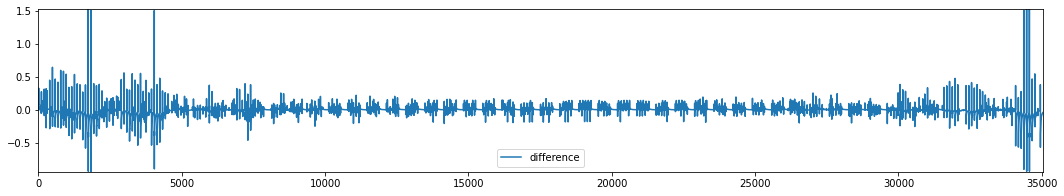

In [6]:
data = pd.DataFrame({k:v['temperature']['air_temperature'] for k, v in data_dict['simulation'].items() if 'temperature' in v.keys()})
data['difference'] = data[-1] - data[0]
data[['difference']].plot(figsize=(18,3))

In [16]:
write_data(data_dict['idf']['modified'],'nb_idf.idf')

In [19]:
a = pd.DataFrame(data_dict['ideal_load'])
a = a[['timestep','cooling_load']].copy()
a.columns = ['timestep','nb_value']
b = pd.read_csv('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/doe_xstock/analysis/load.csv')
b['timestep'] = b.index + 1
b = b[['timestep','cooling']].copy()
b.columns = ['timestep','sc_value']
c = a.merge(b,on='timestep',how='inner').set_index('timestep')
c['diff'] = c['nb_value'] - c['sc_value']
c[['diff']].describe()

,diff
count,3.504000e+04
mean,-5.498116e-15
std,1.085752e-13
min,-9.094947e-13
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,9.094947e-13


<AxesSubplot:>

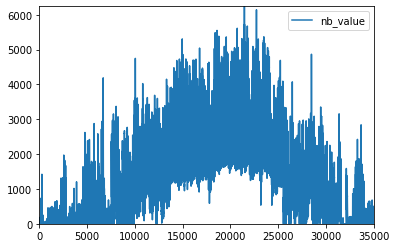

In [22]:
a[['nb_value']].plot()

In [ ]:
# pd.DataFrame({
#     'edited_cooling':data_dict['ideal_load_edited']['cooling_load'],
#     'removed_cooling':data_dict['ideal_load_removed']['cooling_load'],
#     'edited_heating':data_dict['ideal_load_edited']['heating_load'],
#     'removed_heating':data_dict['ideal_load_removed']['heating_load'],
# }).to_csv('test_load.csv',index=False)
# # data.iloc[15000:15090].plot(figsize=(20,3))